## Radiance and Brightness temperature ##
In this exercise, you will  
* use radiance measurements to compute brightness temperature
* perform graphical and statistical comparison of your brightness temperature to the official brightness values
* estimate surface temeprature from radiance 


### Important information for completing this exercise ###
* Locations where you need to add or modify code are marked ```#***```.
* Figures and information that you should turn in with your homework are marked ```#!!!```

In [ ]:
# Import the packages that we will use
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import met4450
except ImportError:
    print('Uh oh!!')
    print('You must have met4450.py in the same directory as this file or somewhere else in your python path')
    
# Planck's constant, J s
h = 6.626e-34
# Speed of light in vacuum, m/s
c = 2.998e8
# Boltzmann's constant, J/K
kB= 1.381e-23

In [ ]:
# Connect to Amazon Web Services public datastores
import s3fs
fs = s3fs.S3FileSystem(anon=True)

### Functions that we will need ###
Begin by defining functions for Planck's law and brightness temperature. Functions reduce repetition and can improve clarity of code.

Recall that Planck's law is
$$B_\lambda(T)=\frac{2hc^2}{\lambda^5(e^{hc/k_B\lambda T}-1)}$$

In [ ]:
# If Python functions are new to you, here is an example of how to define a function that calculates the 
# hypotenuse of a right triangle as a function of the lengths of the other two sides
def hypotenuse(a,b):
    '''Compute length of hypotenuse for a right triangle
    Parameters
    ----------
    a, b : length of two sides of the triangle
    
    Returns
    -------
    length of the hypotenuse
    '''
    return np.sqrt( a**2 + b**2 )

# Enter the lengths of the shorter sides
a=1; b=2
print( 'A right triangle with sides of length {:f} and {:f} units has a hypotenuse with length {:f} units.'.format( a, b, hypotenuse(a,b)) )

In [ ]:
# Define Planck's law as a function of temperature (K) and wavelength (m)
def B(T,lam):
    '''Planck's function for Blackbody radiance
    Parameters
    ----------
    T   : temperature, K
    lam : wavelength, m
        [use "lam" for wavelength because "lambda" has a special meaning in Python]
    
    Returns
    -------
    Radiance, W/m2/sr/m
    '''
    return #*** Enter Planck's function here 

# Define Brightness temperature as a function of intensity (W/m2/m/sr)
def BT(I,lam):
    '''Brightness temperature
    Parameters
    ----------
    I   : intensity, W/m2/sr/m
    lam : wavelength, m
    
    Returns
    -------
    Brightness temperature, K
    '''
    return #*** Enter Planck's function here

In [ ]:
# Here is a test to see if your functions are defined correctly
print('The Planck function for 11µm and 300 K should be 9583696 W/m2/m/sr. Your value is ', B(300,11e-6) )
print('The brightness temperature for 11µm and 9000000 W/m2/m/sr should be 295.7887 K. Your value is ', BT(9000000,11e-6) )
print('Revise your functions if your values differ from the expectation.')

### Fetch Radiance Data ###
In our first GOES exercise, we used the 'ABI-L2-MCMIP' product, which contains reflecance and brightness temperature data.
Now, we will use the Level 1b Radiance product 'ABI-L1b-Rad'. 

In [ ]:
# Find file for a date, time, product and domain of intrest
rad_fileinfo = met4450.find_goes_dataset(
                        satellite=16,
                        product='ABI-L1b-Rad',
                        domain='C',
                        bands=13,
                        datetime='2019-09-02 19:00')

# Print the name of the file that we will read
print( 'Reading file: https://{:s}.s3.amazonaws.com/{:s}'.format( *rad_fileinfo.file[0].split('/',1) ) )
                                          
# Load the data from AWS
goes = xr.open_dataset( fs.open( rad_fileinfo.file[0] ) )

In [ ]:
# Display the data
goes['Rad'].plot.imshow()

### Radiance Units: wavenumber and wavelength ###
Depending on which ABI channel you selected, the radiance units in the figure may use wavelength ('W m-2 sr-1 um-1', channels 1-5) or wavenumber ('mW m-2 sr-1 (cm-1)-1', channels 6-16). As a reminder, wavenumber is defined as $\~\nu=1/\lambda$. In infrared spectroscopy, wavenumber is traditionally measured in units of inverse centimeters (cm-1). Intensity in wavenumber units can be converted to wavelength units through the relationship $I_\lambda d\lambda=I_{\~\nu} d\~\nu$. (The technique is the same as you used previously to derive the frequency form of Planck's law.)

The following block converts all radiance variables to wavelength units of 'W m-2 sr-1 m-1', which should simplify your subsequent code.

In [ ]:
if goes['Rad'].units=='mW m-2 sr-1 (cm-1)-1':
    print('Converting mW m-2 sr-1 (cm-1)-1  ->  W m-2 sr-1 m-1')
    goes['Rad'].values = goes['Rad'] / 1e3 / 100 / (goes.band_wavelength[0]*1e-6)**2
    goes['Rad'].attrs.update({'units':'W m-2 sr-1 m-1',
                              'standard_name':'toa_outgoing_radiance_per_unit_wavelength'})
    
elif goes['Rad'].units=='W m-2 sr-1 um-1':
    # Convert W/m2/sr/um -> W/m2/m/sr
    print('Converting W m-2 sr-1 um-1  ->  W m-2 sr-1 m-1' )
    goes['Rad'].values = goes['Rad'] * 1e6
    goes['Rad'].attrs.update({'units':'W m-2 sr-1 m-1'})
    
elif goes['Rad'].units=='W m-2 sr-1 m-1':
    print('Doing nothing; Units already W m-2 sr-1 m-1')
    pass

else: 
    print( 'Units not recognized: ', goes.Rad.units )

In [ ]:
# Compute brightness temperature, K
goes['my_BT'] = BT( goes['Rad'], goes.band_wavelength[0]*1e-6 )
# Specify units as K
goes['my_BT'].attrs.update({'units':'K'})

In [ ]:
#*** Write a command to display your brightness temperature

#!!! Turn in your figure


### Check your Brightness temperature values ###

We can compare our brightness temperatures to the ones provided by the GOES retrieval team. We need to brightness temperature for the exact same time as the radiances for a fair comparison. 

In [ ]:
# Find the brightness temperature file that matches the time of the radiance file
BT_fileinfo = met4450.find_goes_dataset(
                        satellite=rad_fileinfo.satellite[0],
                        product='ABI-L2-MCMIP',
                        domain=rad_fileinfo.domain[0],
                        datetime=rad_fileinfo.start[0])

# Print the name of the file that we will read
print( 'Reading file: https://{:s}.s3.amazonaws.com/{:s}'.format( *BT_fileinfo.file[0].split('/',1) ) )
                                          
# Load the data from AWS
goes_BT = xr.open_dataset( fs.open( BT_fileinfo.file[0] ) )

In [ ]:
# Make sure that the times for brightness temperature and radiance match
rad_t = goes.t.dt.strftime('%Y-%m-%d %H:%M')
BT_t  = goes_BT.t.dt.strftime('%Y-%m-%d %H:%M')
if rad_t != BT_t:
    print("WARNING!! Time of radiance data ({:s}) doesn't match time of CMI datat ({:s})".format(rad_t, BT_t))
else:
    print('OK. The times are within one minute of each other')

In [ ]:
#*** Plot the brightness temperature for the same ABI channel as you used to calculate your brightness temperature. 
# As a reminder from exercise 1, the brightness temperature variables are named 'CMI_Cxx' where xx is the ABI channel.
# This should look indistinguishable from your values if everything is done correctly


In [ ]:
#*** Plot the difference between between your brightness temperature and the official one from the GOES team.  
# The differences should be less than 1 K.

#!!! Turn in your map of the differences

In [ ]:
#*** Compute the mean difference between your brightness temperature and the official one

#*** Compute the root-mean-square (rms) difference between your brightness temperature and the official one

# Both of these differences should be less than 1 K. 

#!!! Turn in your values for mean and rms difference.

### Land surface temperature ###

We will next estimate land surface temperature from the radiances. NOAA already provides an official land surface temeprature (LST) product, which we will use to check our results.

The following table from Petty's book will be useful.

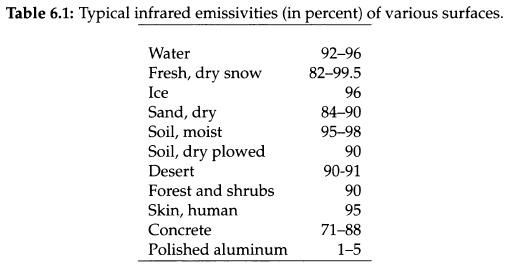


In [ ]:
# Fetch the land surface temperature product
LST_fileinfo = met4450.find_goes_dataset(
                        satellite=rad_fileinfo.satellite[0],
                        product='ABI-L2-LST',
                        domain=rad_fileinfo.domain[0],
                        datetime=rad_fileinfo.start[0])

# Print the name of the file that we will read
print( 'Reading file: https://{:s}.s3.amazonaws.com/{:s}'.format( *LST_fileinfo.file[0].split('/',1) ) )
                                          
# Load the data from AWS
goes_LST = xr.open_dataset( fs.open( LST_fileinfo.file[0] ) )

In [ ]:
#*** Display the Land Surface temperature


In [ ]:
#*** Display the difference between the official LST product and your brightness temperature.
# You should find that they are not the same. Which one is warmer and why?


In [ ]:
#*** Try to make your own estimate of LST by accounting for the emissivity of land surfaces. 
# Test different reasonable values of emissivity to see how close of a match you can make to the official product
goes['my_LST'] = 


# You will find that there is no value of emissivity that provides a good match to the official LST product everywhere.  

#!!! Turn in your best map of land surface temperature. Explain how you created it and answer these questions:
# Why isn't there an emissivity value that provides a good estimate of LST everywhere? Which emissivity values give a reasonable estimate in which locations?